1. Curvas de Precisión-Recall por Clase:
    - Generar curvas de precisión y recall para cada clase, lo que permite ajustar umbrales de decisión específicos para mejorar el equilibrio entre precisión y recall.

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report
import tensorflow as tf
import pickle
import os

2025-05-14 11:27:54.065129: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-14 11:27:54.066059: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-14 11:27:54.073027: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-14 11:27:54.089489: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747236474.124994   77210 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747236474.13

In [2]:
def load_model(model_path):
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"El archivo del modelo no existe: {model_path}")
    model = tf.keras.models.load_model(model_path)
    print(f"Modelo cargado desde {model_path}")
    return model

def load_mlb_objects():
    with open("mlb_partes.pkl", "rb") as f:
        mlb_partes = pickle.load(f)
    with open("mlb_dannos.pkl", "rb") as f:
        mlb_dannos = pickle.load(f)
    with open("mlb_sugerencias.pkl", "rb") as f:
        mlb_sugerencias = pickle.load(f)
    return mlb_partes, mlb_dannos, mlb_sugerencias

def load_test_data(test_csv_path):
    import pandas as pd
    import json
    df = pd.read_csv(test_csv_path, sep='|')
    for col in ['dannos', 'partes', 'sugerencias']:
        df[col] = df[col].apply(lambda x: json.loads(x) if isinstance(x, str) else x)
    return df

def get_class_names(classes, label_dict):
    return [str(label_dict.get(int(cls), f"Clase_{cls}")) for cls in classes]

def plot_precision_recall_per_class(y_true, y_scores, class_names, title_prefix):
    n_classes = y_true.shape[1]
    plt.figure(figsize=(20, 15))
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_scores[:, i])
        ap = average_precision_score(y_true[:, i], y_scores[:, i])
        plt.plot(recall, precision, lw=2, label=f'{class_names[i]} (AP={ap:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Curvas Precision-Recall para {title_prefix}')
    plt.legend(loc='best', fontsize='small')
    plt.grid(True)
    plt.show()

def evaluate_model(model, test_df, mlb_partes, mlb_dannos, mlb_sugerencias,
                   label_to_cls_piezas, label_to_cls_danos, label_to_cls_sugerencias):
    # Transformar etiquetas verdaderas
    y_true_partes = mlb_partes.transform(test_df['partes'])
    y_true_dannos = mlb_dannos.transform(test_df['dannos'])
    y_true_sugerencias = mlb_sugerencias.transform(test_df['sugerencias'])

    # Generar predicciones (scores)
    # Para predicciones batch, se debe crear un generador o procesar por lotes
    # Aquí se asume que el test_df tiene una columna 'Imagen' con la ruta relativa a las imágenes
    IMG_DIR = '../data/fotos_siniestros/'
    from tensorflow.keras.preprocessing.image import load_img, img_to_array
    X_test = []
    for img_name in test_df['Imagen']:
        img_path = os.path.join(IMG_DIR, img_name)
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
        X_test.append(img_array)
    X_test = np.array(X_test)

    predictions = model.predict(X_test, batch_size=32, verbose=1)
    y_scores_partes = predictions[0]
    y_scores_dannos = predictions[1]
    y_scores_sugerencias = predictions[2]

    # Binarizar predicciones con umbral 0.5 para reporte clasificación
    y_pred_partes = y_scores_partes > 0.5
    y_pred_dannos = y_scores_dannos > 0.5
    y_pred_sugerencias = y_scores_sugerencias > 0.5

    partes_names = get_class_names(mlb_partes.classes_, label_to_cls_piezas)
    dannos_names = get_class_names(mlb_dannos.classes_, label_to_cls_danos)
    sugerencias_names = get_class_names(mlb_sugerencias.classes_, label_to_cls_sugerencias)

    print("\nReporte para Partes:")
    print(classification_report(y_true_partes, y_pred_partes, target_names=partes_names, zero_division=0))

    print("\nReporte para Daños:")
    print(classification_report(y_true_dannos, y_pred_dannos, target_names=dannos_names, zero_division=0))

    print("\nReporte para Sugerencias:")
    print(classification_report(y_true_sugerencias, y_pred_sugerencias, target_names=sugerencias_names, zero_division=0))

    print("\nGenerando curvas Precision-Recall para Partes...")
    plot_precision_recall_per_class(y_true_partes, y_scores_partes, partes_names, "Partes")

    print("\nGenerando curvas Precision-Recall para Daños...")
    plot_precision_recall_per_class(y_true_dannos, y_scores_dannos, dannos_names, "Daños")

    print("\nGenerando curvas Precision-Recall para Sugerencias...")
    plot_precision_recall_per_class(y_true_sugerencias, y_scores_sugerencias, sugerencias_names, "Sugerencias")

2025-05-14 11:28:00.951469: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Modelo cargado desde final_model_fine_tuned_v2.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step

Reporte para Partes:
                                    precision    recall  f1-score   support

    Antiniebla delantero izquierdo       0.00      0.00      0.00         2
                              Capó       0.00      0.00      0.00        16
            Espejo lateral derecho       0.00      0.00      0.00         2
                     Faros derecho       0.00      0.00      0.00        15
                   Faros izquierdo       0.00      0.00      0.00        14
    Guardabarros delantero derecho       0.00      0.00      0.00        22
  Guardabarros delantero izquierdo       0.00      0.00      0.00        23
      Guardabarros trasero derecho       0.00      0.00      0.00        13
    Guardabarros trasero izquierdo       0.00      0.00      0.00        15
  Luz indicadora delantera derecha       0.00      0.00      0.00         2
Luz indicadora delantera izquierda       0.00      

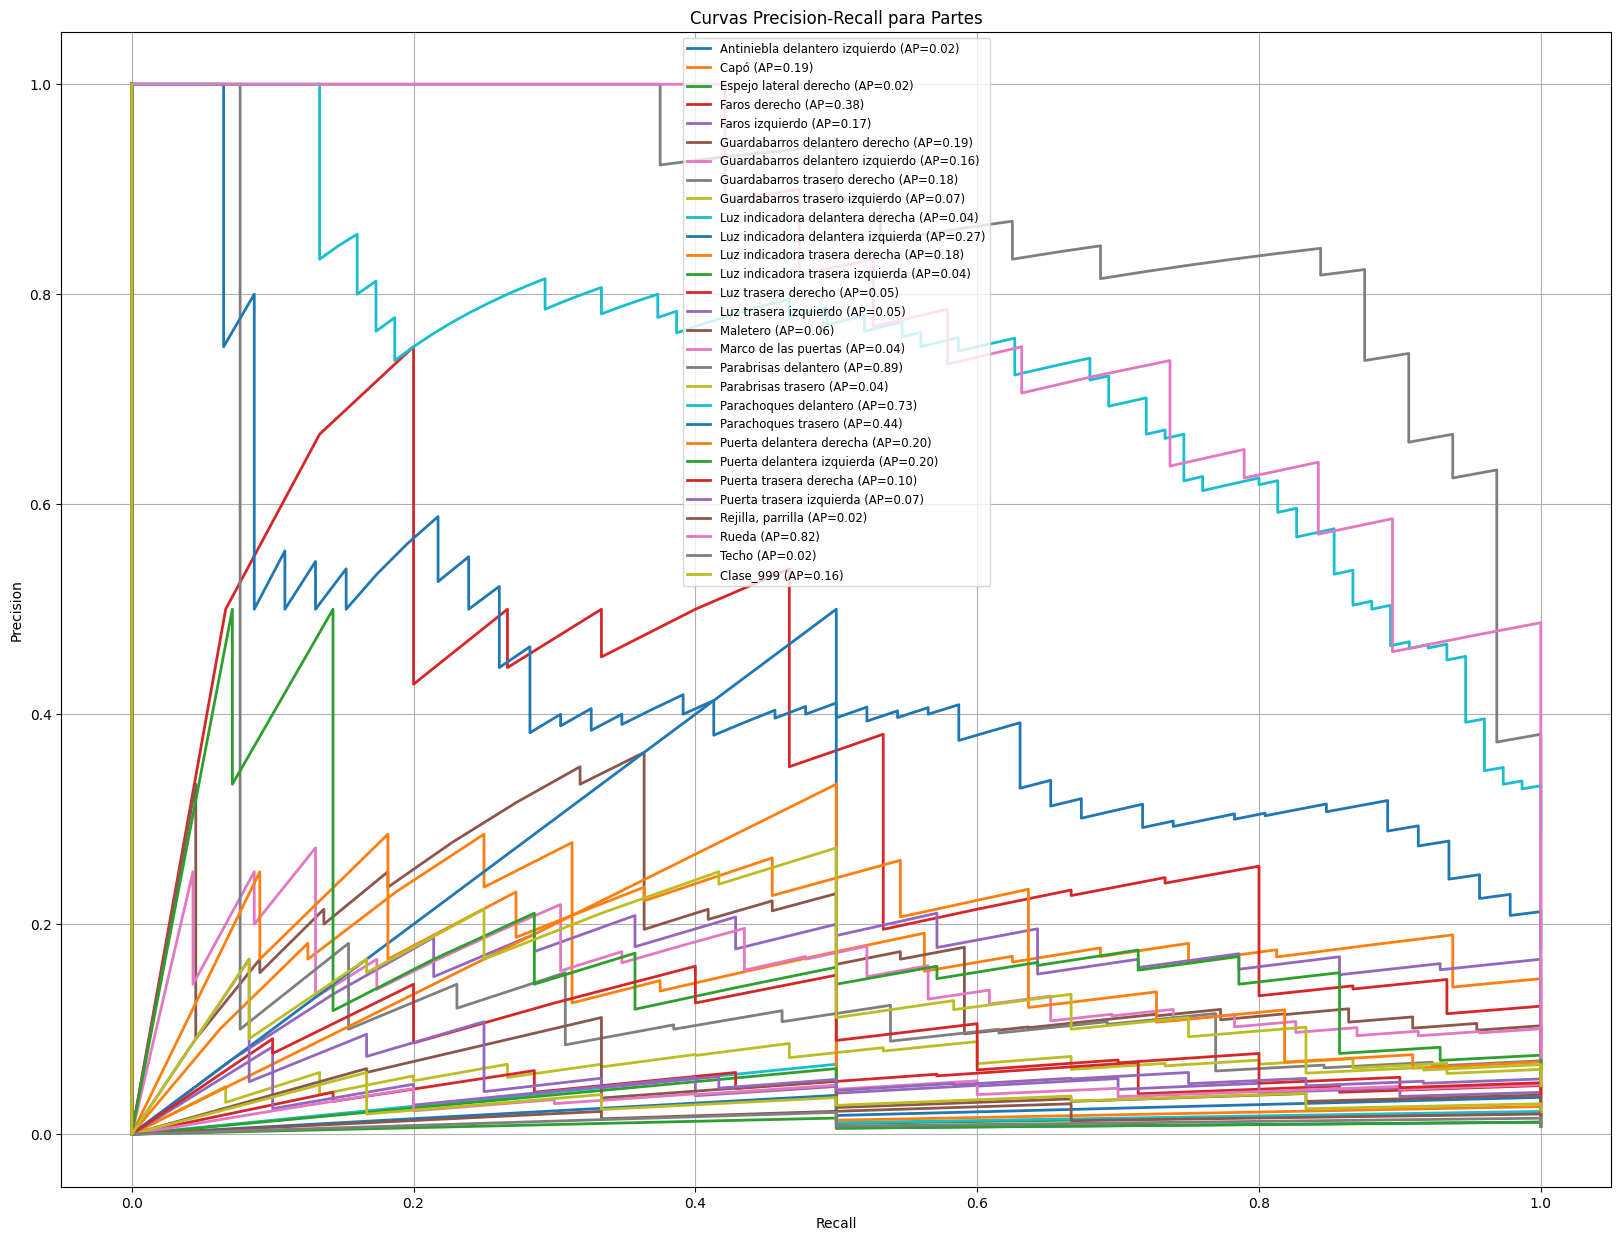


Generando curvas Precision-Recall para Daños...


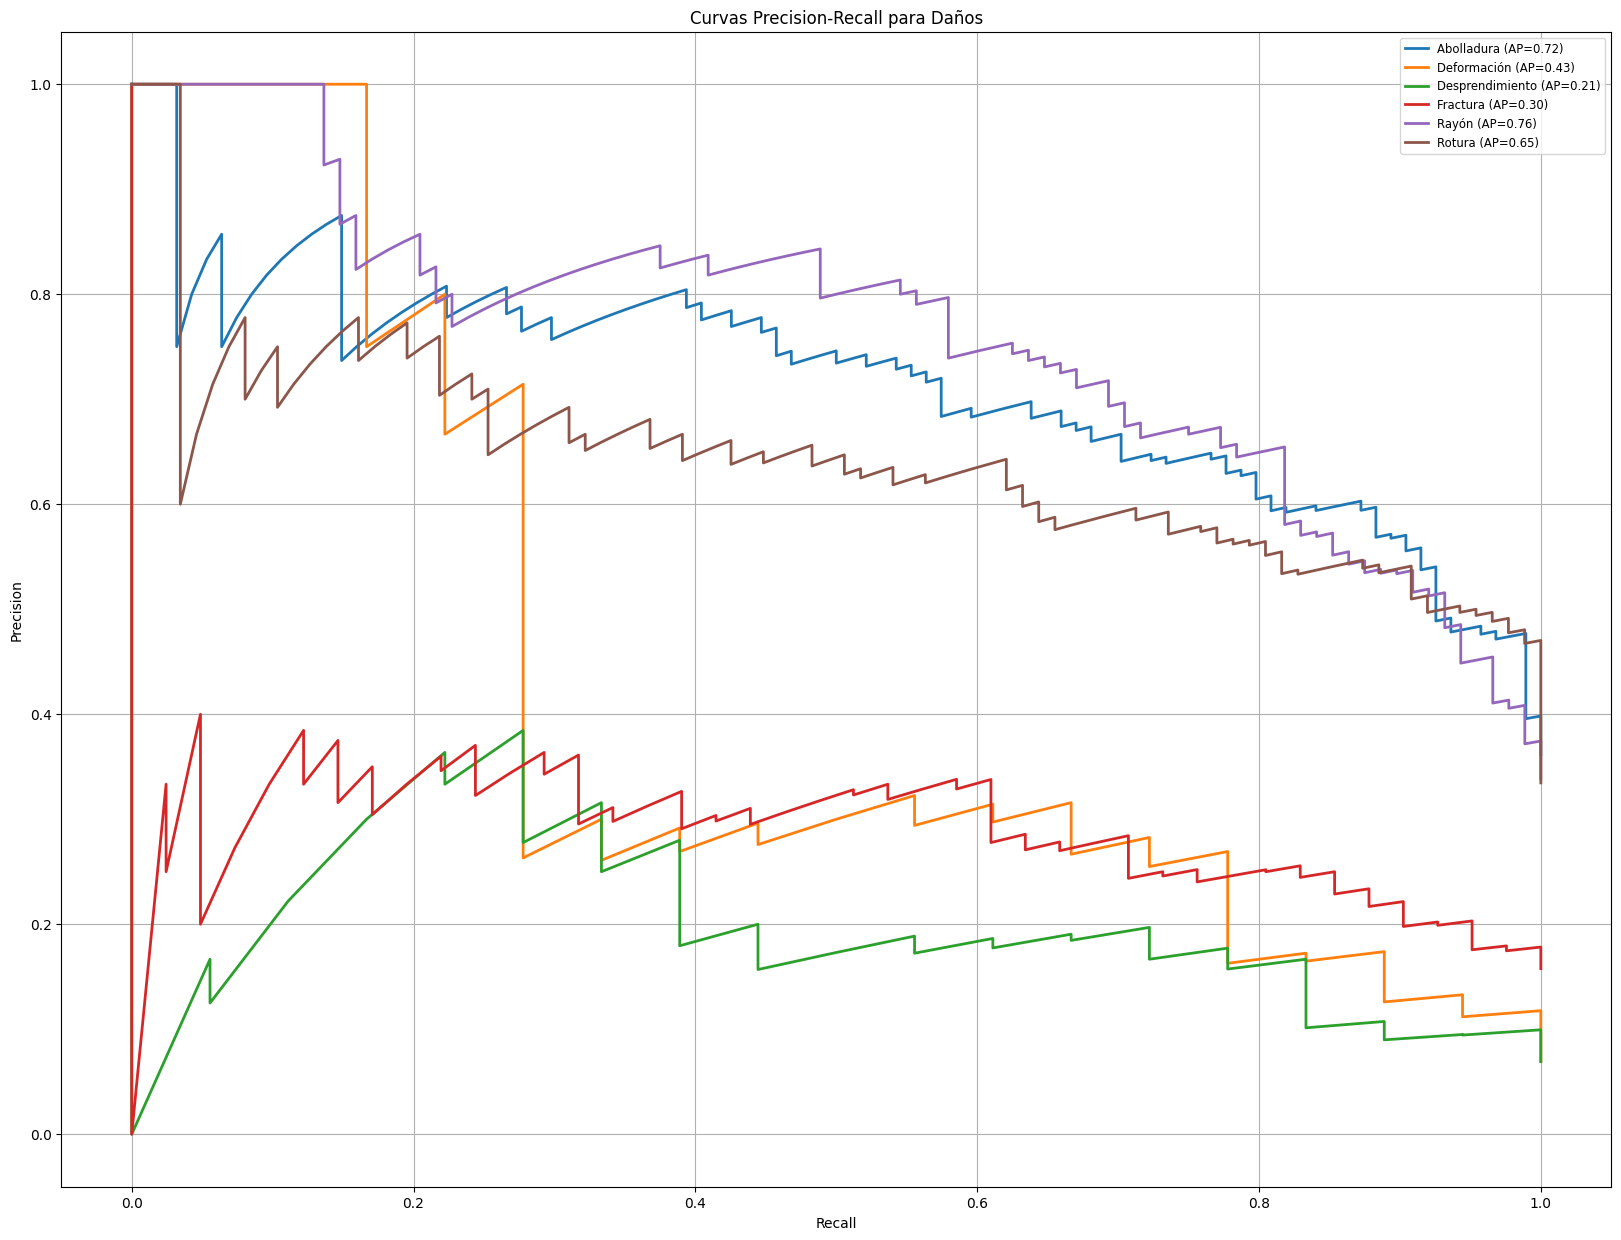


Generando curvas Precision-Recall para Sugerencias...


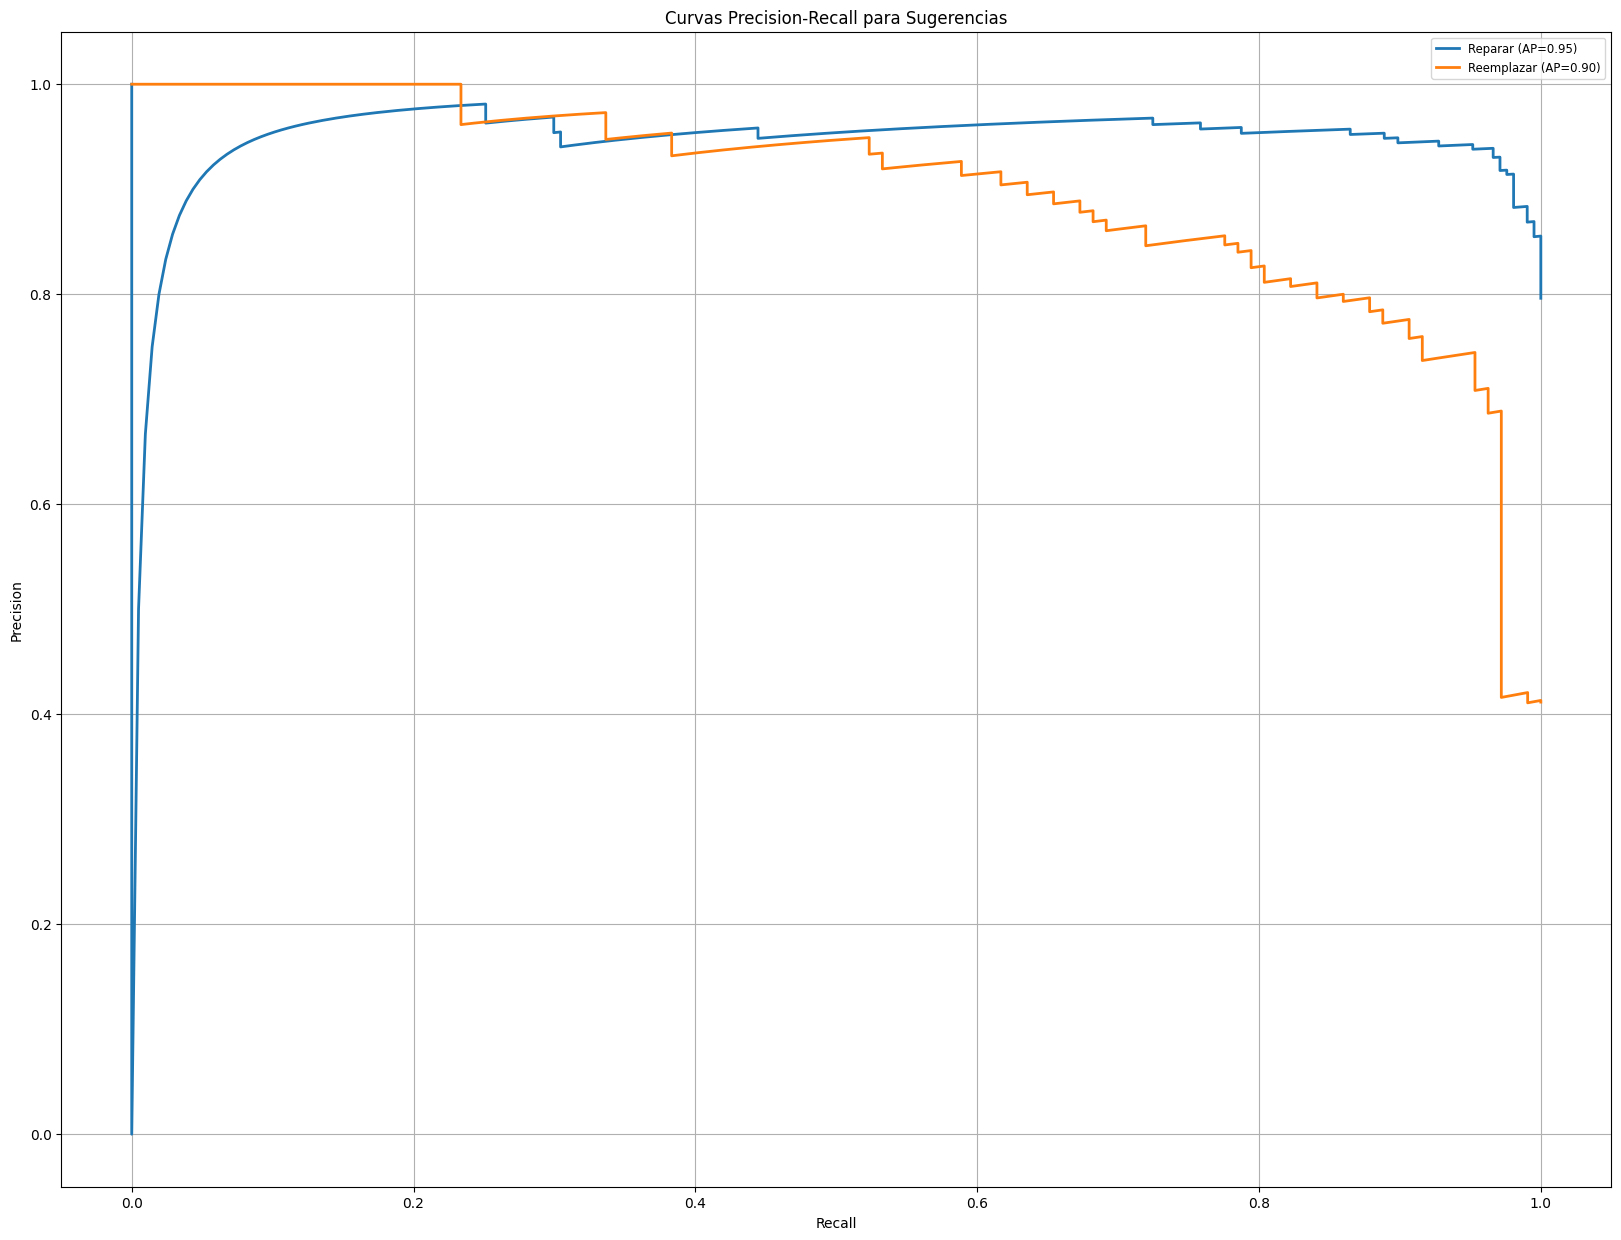

In [3]:
if __name__ == "__main__":
    # Diccionarios de mapeo (deben coincidir con los usados en el entrenamiento)
    label_to_cls_piezas = {
        1: "Antiniebla delantero derecho",
        2: "Antiniebla delantero izquierdo",
        3: "Capó",
        4: "Cerradura capo",
        5: "Cerradura maletero",
        6: "Cerradura puerta",
        7: "Espejo lateral derecho",
        8: "Espejo lateral izquierdo",
        9: "Faros derecho",
        10: "Faros izquierdo",
        11: "Guardabarros delantero derecho",
        12: "Guardabarros delantero izquierdo",
        13: "Guardabarros trasero derecho",
        14: "Guardabarros trasero izquierdo",
        15: "Luz indicadora delantera derecha",
        16: "Luz indicadora delantera izquierda",
        17: "Luz indicadora trasera derecha",
        18: "Luz indicadora trasera izquierda",
        19: "Luz trasera derecho",
        20: "Luz trasera izquierdo",
        21: "Maletero",
        22: "Manija derecha",
        23: "Manija izquierda",
        24: "Marco de la ventana",
        25: "Marco de las puertas",
        26: "Moldura capó",
        27: "Moldura puerta delantera derecha",
        28: "Moldura puerta delantera izquierda",
        29: "Moldura puerta trasera derecha",
        30: "Moldura puerta trasera izquierda",
        31: "Parabrisas delantero",
        32: "Parabrisas trasero",
        33: "Parachoques delantero",
        34: "Parachoques trasero",
        35: "Puerta delantera derecha",
        36: "Puerta delantera izquierda",
        37: "Puerta trasera derecha",
        38: "Puerta trasera izquierda",
        39: "Rejilla, parrilla",
        40: "Rueda",
        41: "Tapa de combustible",
        42: "Tapa de rueda",
        43: "Techo",
        44: "Techo corredizo",
        45: "Ventana delantera derecha",
        46: "Ventana delantera izquierda",
        47: "Ventana trasera derecha",
        48: "Ventana trasera izquierda",
        49: "Ventanilla delantera derecha",
        50: "Ventanilla delantera izquierda",
        51: "Ventanilla trasera derecha",
        52: "Ventanilla trasera izquierda"
    }

    label_to_cls_danos = {
        1: "Abolladura",
        2: "Deformación",
        3: "Desprendimiento",
        4: "Fractura",
        5: "Rayón",
        6: "Rotura"
    }

    label_to_cls_sugerencias = {
        1: "Reparar",
        2: "Reemplazar"
    }

    model_path = "final_model_fine_tuned_v2.keras"
    test_csv_path = "data/fotos_siniestros/test/test_set.csv"

    model = load_model(model_path)
    mlb_partes, mlb_dannos, mlb_sugerencias = load_mlb_objects()
    test_df = load_test_data(test_csv_path)

    evaluate_model(model, test_df, mlb_partes, mlb_dannos, mlb_sugerencias,
                   label_to_cls_piezas, label_to_cls_danos, label_to_cls_sugerencias)

---